# Guided Project : Predicting House Sale Prices

# Introduction

In [28]:
# importing libraries & classes into the environment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [15]:
from copy import deepcopy
df = pd.read_csv('AmesHousing.tsv', delimiter = '\t')

def transform_features(train):
    return train

def select_features(train):
    return train[['Gr Liv Area', 'SalePrice']]

def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    features = train.select_dtypes(include=['integer', 'float'])
    features = features.drop(['SalePrice'], axis=1)
    print(features.columns)
    lr = LinearRegression()
    lr.fit(train[features.columns], train['SalePrice'])
    predictions = lr.predict(test[features.columns])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = (mse)**(1/2)
    return rmse

transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
print(rmse)
df.head(3)

Index(['Gr Liv Area'], dtype='object')
57088.2516126


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


# 2. Feature Engineering

Removing features with ma ny missing values:

*1) potential categorial features
*2) transforming text columns
*3) transforming numerical columns

* any column from the data frame with more than 25% missing values is dropped
* HANDLE DATA LEAKAGE: 
remove any columns that leak information about the sale (e.g. like the year the sale happened)
* transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
* create new features by combining other features


1) __For Now__ drop columns with 5% or more missing values

In [16]:
num_missing = df.isnull().sum()
drop_missing_cols = num_missing[num_missing > (len(df)/20)].sort_values()
df.drop(drop_missing_cols.index, axis =1)
df.shape

(2930, 82)

2) text column: __For now__ drop any column with 1 or more missing value

In [17]:
text_df = df.select_dtypes(include=['object'])
text_missing_count = text_df.isnull().sum()
drop_missing_text_cols = text_missing_count[text_missing_count > 0]
df = df.drop(drop_missing_text_cols.index, axis=1)
df.shape

(2930, 66)

3) Numerical column: For more than 5% missing column, replace with most common value of the column

In [18]:
numeric_df =  df.select_dtypes(include=['integer', 'float'])
length = numeric_df.shape[0]
numeric_missing_count = numeric_df.isnull().sum()
numeric_missing_col_name = numeric_missing_count[(numeric_missing_count<(length/20))& (numeric_missing_count>0)].index


In [19]:
replacement_values_dict = df[numeric_missing_col_name].mode().to_dict(orient='records')[0]
replacement_values_dict

df = df.fillna(replacement_values_dict)
df.shape
df.isnull().sum().value_counts()

0      64
490     1
159     1
dtype: int64

4) Creating new features: 'Years Before Sale', and 'Years until Remod'

In [20]:
df['Years Before Sale'] = df['Yr Sold'] - df['Year Built']
print(df[df['Years Before Sale'] <0].index.values)
df['Years until Remod/Add'] = df['Yr Sold'] - df['Year Remod/Add']
print(df[df['Years until Remod/Add'] <0].index.values)
df.drop([1702, 2180, 2181], axis =0)
#dropping original columns
df = df.drop(['Year Built', 'Year Remod/Add'], axis =1)

[2180]
[1702 2180 2181]


5) Drop columns that aren't useful in ML : 'PID', 'Order'

In [21]:
df = df.drop(['PID', 'Order'], axis =1)

6) Dropping columns that leak data : "Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"

In [22]:
df = df.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis =1)
df.head()


,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years until Remod/Add
0,20,RL,141.0,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,210,62,0,0,0,0,0,215000,50,50
1,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,140,0,0,0,120,0,0,105000,49,49
2,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,393,36,0,0,0,0,12500,172000,52,52
3,20,RL,93.0,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,0,0,244000,42,42
4,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,212,34,0,0,0,0,0,189900,13,12


# transforming features()

In [23]:

def transform_features(df):
    num_missing = df.isnull().sum()
    drop_missing_cols = num_missing[(num_missing > len(df)/20)].sort_values()
    df = df.drop(drop_missing_cols.index, axis=1)
    
    text_mv_counts = df.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    drop_missing_cols_2 = text_mv_counts[text_mv_counts > 0]
    df = df.drop(drop_missing_cols_2.index, axis=1)
    
    num_missing = df.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing < len(df)/20) & (num_missing > 0)].sort_values()
    replacement_values_dict = df[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    df = df.fillna(replacement_values_dict)
    
    years_sold = df['Yr Sold'] - df['Year Built']
    years_since_remod = df['Yr Sold'] - df['Year Remod/Add']
    df['Years Before Sale'] = years_sold
    df['Years Since Remod'] = years_since_remod
    df = df.drop([1702, 2180, 2181], axis=0)

    df = df.drop(["PID", "Order", "Mo Sold", "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add"], axis=1)
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.367312413073

# 3. Feature Selection

1) Correlation Matrix HeatMap

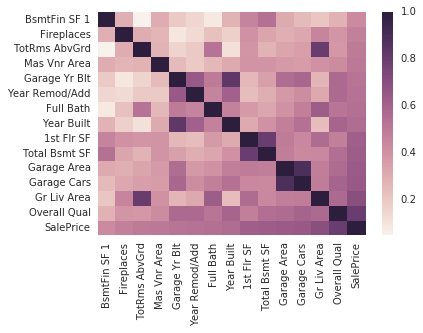

In [24]:
%matplotlib inline
import seaborn as sns
corrmat = df.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
strong_corrs = sorted_corrs[sorted_corrs > 0.4]
corrmat = df[strong_corrs.index].corr()
sns.heatmap(corrmat)
plt.show()

In [25]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1)
    
    return df

# 4. Train and Test

In [ ]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

print(rmse